### Running a pretrained VGG model

Compared to the 8 layers and 60 million parameters of AlexNet, VGG consists of 13 layers (10
convolutional layers and 3 fully connected layers) and 138 million parameters. VGG basically stacks
more layers onto the AlexNet architecture with smaller convolution kernels (2x2 or 3x3).

In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

torch.use_deterministic_algorithms(True)

In [3]:
ddir = './data/versions/1/hymenoptera_data'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ])
}

img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transforms[k]) for k in ['train', 'val']}
data_loaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8, shuffle=True, num_workers=4) for k in ['train', 'val']}
data_sizes = {k: len(img_data[k]) for k in ['train', 'val']}
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import ast
with open("./data/imagenet1000_clsidx_to_labels.txt") as f:
    classes_data = f.read()
classes_dict = ast.literal_eval(classes_data)
print({k: classes_dict[k] for k in list(classes_dict)[:5]})

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark'}


In [7]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.490, 0.449, 0.411])
    std = np.array([0.231, 0.221, 0.230])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

def visualize_predictions(pretrained_model, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(dvc)
            labels = labels.to(dvc)

            outputs = pretrained_model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'predicted: {classes_dict[int(preds[j])]}')
                imageshow(inputs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

In [9]:
model = models.vgg13(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /Users/lyteatnyte/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [09:09<00:00, 968kB/s]  


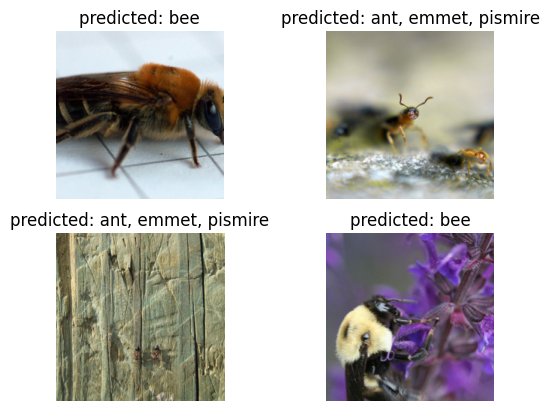

In [10]:
visualize_predictions(model)

Basically, the model grabs the two most similar animals
from the dataset out of the 1,000 classes and finds them in the images. By doing this exercise,
we see that the model is still able to extract relevant visual features out of the images and the
exercise demonstrates the utility of PyTorch’s out-of-the-box inference feature.